In [55]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
!pip install flaml
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.1/216.1 kB 5.2 MB/s eta 0:00:0000:01
/kaggle/input/playground-series-s3e3/sample_submission.csv
/kaggle/input/playground-series-s3e3/train.csv
/kaggle/input/playground-series-s3e3/test.csv


In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,recall_score
from sklearn.utils import resample

In [57]:
df_train = pd.read_csv("/kaggle/input/playground-series-s3e3/train.csv")
df_test = pd.read_csv("/kaggle/input/playground-series-s3e3/test.csv")
df_train

,id,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,0,36,Travel_Frequently,599,Research & Development,24,3,Medical,1,4,...,80,1,10,2,3,10,0,7,8,0
1,1,35,Travel_Rarely,921,Sales,8,3,Other,1,1,...,80,1,4,3,3,4,2,0,3,0
2,2,32,Travel_Rarely,718,Sales,26,3,Marketing,1,3,...,80,2,4,3,3,3,2,1,2,0
3,3,38,Travel_Rarely,1488,Research & Development,2,3,Medical,1,3,...,80,0,15,1,1,6,0,0,2,0
4,4,50,Travel_Rarely,1017,Research & Development,5,4,Medical,1,2,...,80,0,31,0,3,31,14,4,10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1672,1672,30,Travel_Rarely,945,Sales,1,3,Life Sciences,1,4,...,80,0,10,2,4,10,0,0,8,0
1673,1673,32,Travel_Rarely,1303,Research & Development,2,3,Life Sciences,1,1,...,80,1,10,3,4,4,2,1,3,0
1674,1674,29,Travel_Frequently,1184,Human Resources,24,3,Human Resources,1,2,...,80,0,1,2,3,1,0,0,0,1
1675,1675,36,Travel_Rarely,441,Sales,9,2,Marketing,1,2,...,80,2,10,3,2,10,3,0,8,0


In [58]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1677 entries, 0 to 1676
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        1677 non-null   int64 
 1   Age                       1677 non-null   int64 
 2   BusinessTravel            1677 non-null   object
 3   DailyRate                 1677 non-null   int64 
 4   Department                1677 non-null   object
 5   DistanceFromHome          1677 non-null   int64 
 6   Education                 1677 non-null   int64 
 7   EducationField            1677 non-null   object
 8   EmployeeCount             1677 non-null   int64 
 9   EnvironmentSatisfaction   1677 non-null   int64 
 10  Gender                    1677 non-null   object
 11  HourlyRate                1677 non-null   int64 
 12  JobInvolvement            1677 non-null   int64 
 13  JobLevel                  1677 non-null   int64 
 14  JobRole                 

In [59]:
num_col = []
cat_col =[]
for col in df_train.columns:
    if df_train[col].dtype=="int64":
        num_col.append(col)
    else:
        cat_col.append(col)
print("Numerical feaures: \n {} \n\n Categorical features : \n {} ".format(num_col,cat_col))

Numerical feaures: 
 ['id', 'Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'Attrition'] 

 Categorical features : 
 ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime'] 


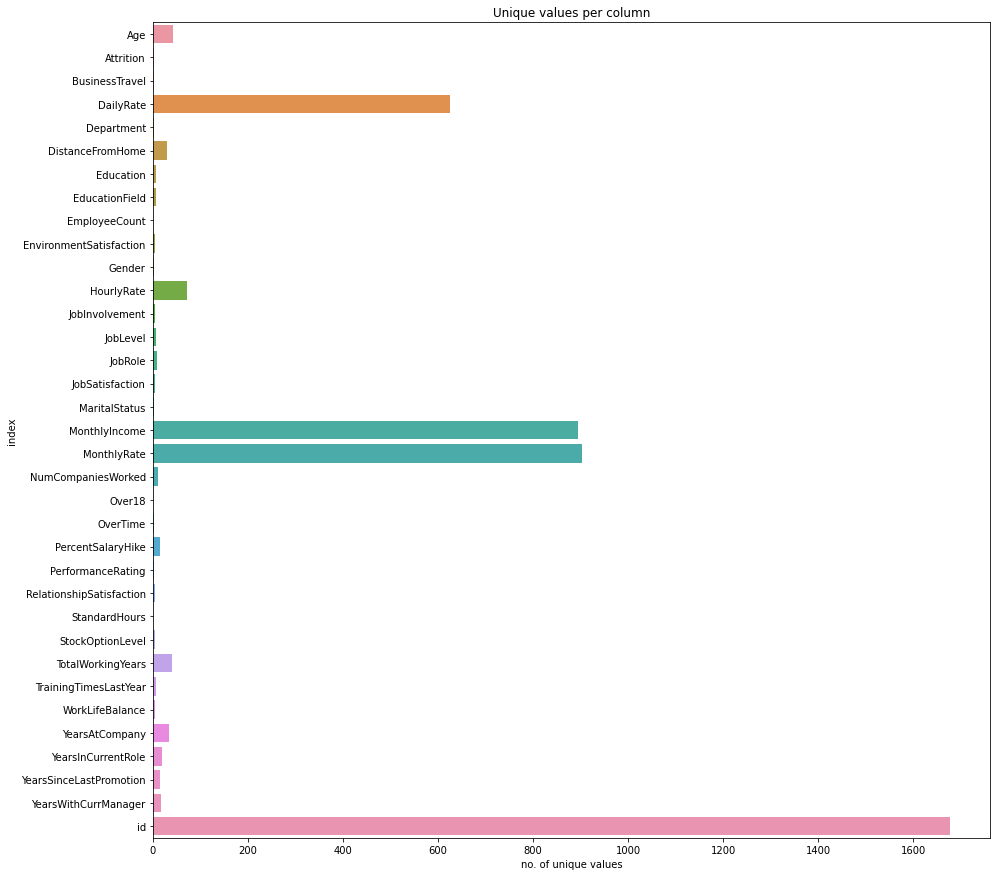

In [60]:
l = {}
for col in df_train.columns:
    l[col]=len(df_train[col].unique())
   # print(len(df_train[col].unique()),"   ",col)
myKeys = list(l.keys())
myKeys.sort()
l_sort = {i: l[i] for i in myKeys}
df_unique_values = pd.DataFrame.from_dict(l_sort,orient="index",columns=["no. of unique values"])
df_unique_values.reset_index(inplace=True)
plt.figure(figsize=(15,15))
plt.title("Unique values per column")
sns.barplot(x="no. of unique values",y="index",data=df_unique_values)
plt.show()
#l

Not all columns are important , in order to visualize the distribution of columns when target=1 , we are only going to select those columns whose 40<=unique<=1000.

In [61]:
imp_col=[]
for col in num_col:
    if len(df_train[col].unique())>=40 and len(df_train[col].unique())<1000:
        imp_col.append(col)
imp_col

['Age',
 'DailyRate',
 'HourlyRate',
 'MonthlyIncome',
 'MonthlyRate',
 'TotalWorkingYears']

now we shall she the distributions of these attributes when we have a positive attrition.

In [62]:
positive_attritions = len(df_train[df_train["Attrition"]==1])
positive_attritions

200

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

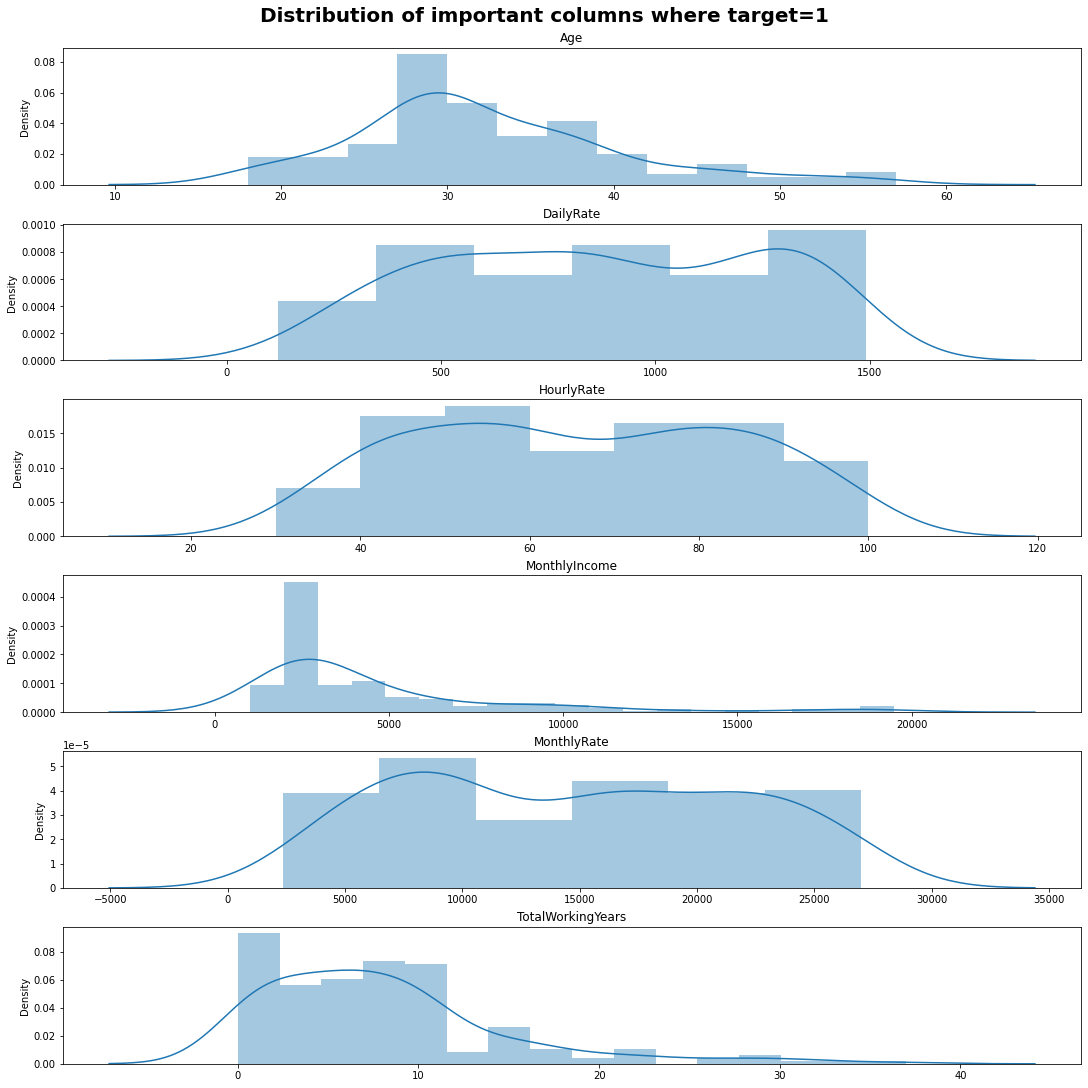

In [63]:
fig, axes = plt.subplots(len(imp_col), 1, figsize=(15, 15),constrained_layout=True)
fig.suptitle("Distribution of important columns where target=1",fontsize=20,fontweight="bold")
for i,col in zip(range(len(imp_col)),imp_col):
    sns.distplot(ax=axes[i],x=df_train[df_train["Attrition"]==1][col])
    axes[i].set_title(col)
plt.show()

From the above plots it can be inferred that :
* people around the age of 30 are prone to attrition
* people with monthly income between 0-5000 have high attrition rate
* people with working years between 0-10 are prone to attrtion

In [64]:
for col in cat_col:
    print(col,"\n",df_train[col].value_counts(),"\n\n")

BusinessTravel 
 Travel_Rarely        1290
Travel_Frequently     261
Non-Travel            126
Name: BusinessTravel, dtype: int64 


Department 
 Research & Development    1167
Sales                      471
Human Resources             39
Name: Department, dtype: int64 


EducationField 
 Life Sciences       775
Medical             549
Marketing           152
Technical Degree    106
Other                82
Human Resources      13
Name: EducationField, dtype: int64 


Gender 
 Male      1064
Female     613
Name: Gender, dtype: int64 


JobRole 
 Sales Executive              355
Research Scientist           344
Laboratory Technician        334
Manufacturing Director       196
Healthcare Representative    155
Manager                      111
Sales Representative          77
Research Director             71
Human Resources               34
Name: JobRole, dtype: int64 


MaritalStatus 
 Married     773
Single      577
Divorced    327
Name: MaritalStatus, dtype: int64 


Over18 
 Y    1677
N

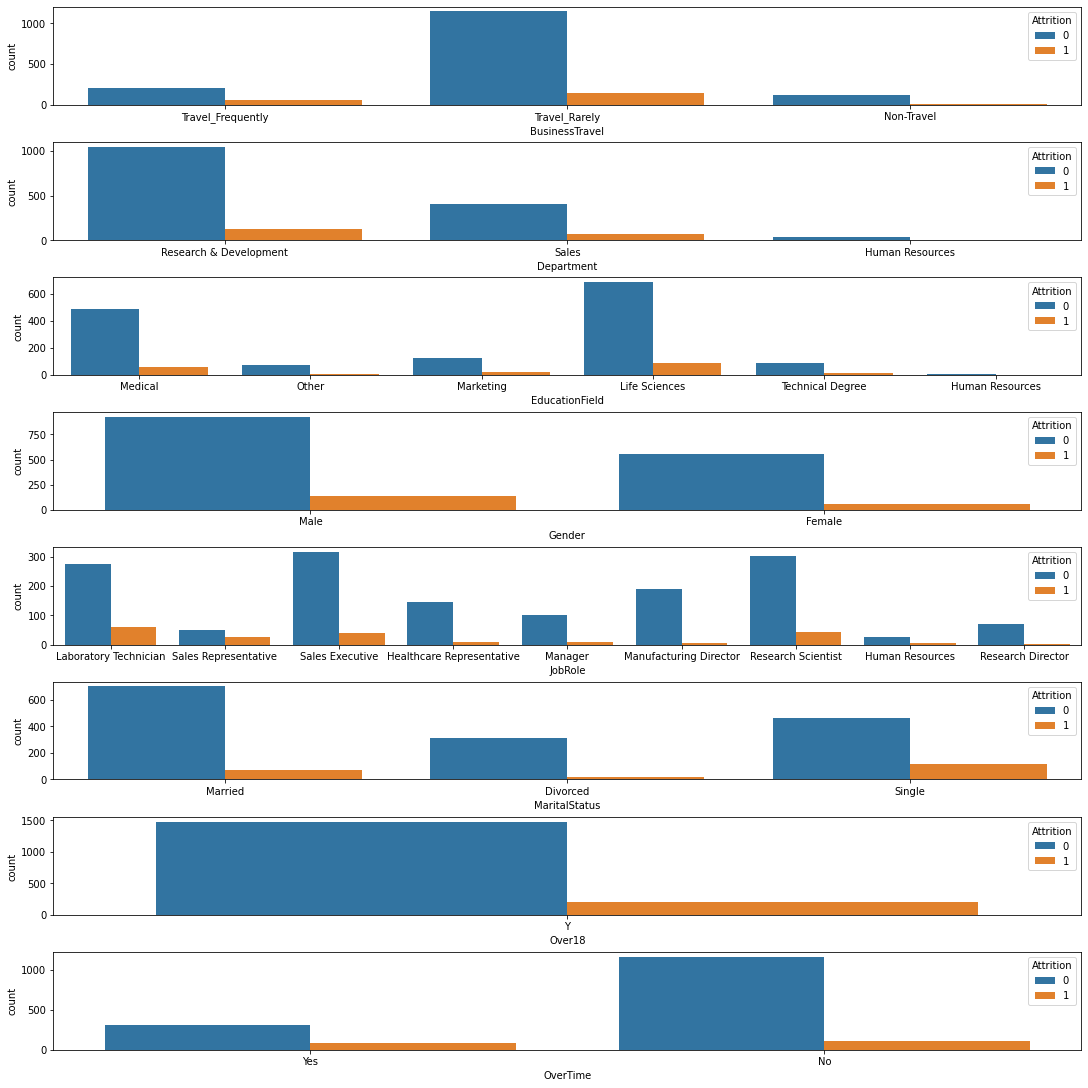

In [65]:
figure,axx = plt.subplots(len(cat_col),figsize=(15,15),constrained_layout=True)
for i, col in zip(range(len(cat_col)),cat_col):
    sns.countplot(ax=axx[i],x=df_train[col],hue=df_train['Attrition'],)
    #axx[i].set_title(col)
plt.show()

In [66]:
#trim_df = df_train.drop(columns=['Over18',"id"])
encoder=ce.TargetEncoder(cols=cat_col)
new_df=encoder.fit_transform(df_train,df_train['Attrition'])
new_df.drop(columns=["Over18","id","OverTime","MaritalStatus","BusinessTravel"],inplace=True)
new_df

/opt/conda/lib/python3.7/site-packages/category_encoders/target_encoder.py:124: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)
/opt/conda/lib/python3.7/site-packages/category_encoders/target_encoder.py:129: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)


,Age,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,HourlyRate,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,36,599,0.107969,24,3,0.114754,1,4,0.129699,42,...,80,1,10,2,3,10,0,7,8,0
1,35,921,0.142251,8,3,0.073171,1,1,0.129699,46,...,80,1,4,3,3,4,2,0,3,0
2,32,718,0.142251,26,3,0.171053,1,3,0.129699,80,...,80,2,4,3,3,3,2,1,2,0
3,38,1488,0.107969,2,3,0.114754,1,3,0.101142,40,...,80,0,15,1,1,6,0,0,2,0
4,50,1017,0.107969,5,4,0.114754,1,2,0.101142,37,...,80,0,31,0,3,31,14,4,10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1672,30,945,0.142251,1,3,0.113548,1,4,0.101142,73,...,80,0,10,2,4,10,0,0,8,0
1673,32,1303,0.107969,2,3,0.113548,1,1,0.129699,48,...,80,1,10,3,4,4,2,1,3,0
1674,29,1184,0.179487,24,3,0.230769,1,2,0.129699,36,...,80,0,1,2,3,1,0,0,0,1
1675,36,441,0.142251,9,2,0.171053,1,2,0.129699,48,...,80,2,10,3,2,10,3,0,8,0


In [67]:
df_minority = new_df[new_df.Attrition==1]
df_majority = new_df[new_df.Attrition==0]
df_majority_downsampled = resample(df_majority, 
                                 replace=True,     # sample with replacement
                                 n_samples=200,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_downsampled = pd.concat([df_minority, df_majority_downsampled])
 
# Display new class counts
df_downsampled.Attrition.value_counts()

1    200
0    200
Name: Attrition, dtype: int64

In [68]:
X = df_downsampled.drop(columns=["Attrition"])
y = df_downsampled['Attrition']
x_train,x_test,y_train,y_test = train_test_split(X,y,random_state=42,test_size=0.2)
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)


In [82]:
performance={}
models=[LogisticRegression(),KNeighborsClassifier(n_neighbors=5),RandomForestClassifier(),GaussianNB(),SGDClassifier()]
for model in models:
    model.fit(x_train_scaled,y_train)
    preds = model.predict(x_test)
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test,preds)
    recall = recall_score(y_test,preds)
    performance[model] = [acc,f1,recall]
    
performance_data = pd.DataFrame.from_dict(performance)
performance_data
#performance

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SGDC

LogisticRegression()  KNeighborsClassifier()  \
0              0.450000                0.550000   
1              0.521739                0.560976   
2              0.545455                0.522727   

   (DecisionTreeClassifier(max_features='auto', random_state=1267647914), DecisionTreeClassifier(max_features='auto', random_state=354378413), DecisionTreeClassifier(max_features='auto', random_state=227194772), DecisionTreeClassifier(max_features='auto', random_state=1767324244), DecisionTreeClassifier(max_features='auto', random_state=766643052), DecisionTreeClassifier(max_features='auto', random_state=1440360708), DecisionTreeClassifier(max_features='auto', random_state=1921038202), DecisionTreeClassifier(max_features='auto', random_state=233260277), DecisionTreeClassifier(max_features='auto', random_state=150013051), DecisionTreeClassifier(max_features='auto', random_state=112585352), DecisionTreeClassifier(max_features='auto', random_state=784379050), DecisionTreeClassifier(max_features='auto', random_state=439393877), DecisionTreeClassifier(max_features='auto', random_state=1526816792), DecisionTreeClassifier(max_features='auto', random_state=167549122), DecisionTreeClassifier(max_features='auto', random_state=1639575588), DecisionTreeClassifier(max_features='auto', random_state=33251027), DecisionTreeClassifier(max_features='auto', random_state=317444078), DecisionTreeClassifier(max_features='auto', random_state=1270469898), DecisionTreeClassifier(max_features='auto', random_state=1447065328), DecisionTreeClassifier(max_features='auto', random_state=2101193389), DecisionTreeClassifier(max_features='auto', random_state=1381584906), DecisionTreeClassifier(max_features='auto', random_state=961119634), DecisionTreeClassifier(max_features='auto', random_state=1398754719), DecisionTreeClassifier(max_features='auto', random_state=1598607871), DecisionTreeClassifier(max_features='auto', random_state=1826741124), DecisionTreeClassifier(max_features='auto', random_state=1561635441), DecisionTreeClassifier(max_features='auto', random_state=68032288), DecisionTreeClassifier(max_features='auto', random_state=1733289139), DecisionTreeClassifier(max_features='auto', random_state=949496483), DecisionTreeClassifier(max_features='auto', random_state=427362545), DecisionTreeClassifier(max_features='auto', random_state=2065169703), DecisionTreeClassifier(max_features='auto', random_state=872486176), DecisionTreeClassifier(max_features='auto', random_state=121618117), DecisionTreeClassifier(max_features='auto', random_state=494645485), DecisionTreeClassifier(max_features='auto', random_state=682905950), DecisionTreeClassifier(max_features='auto', random_state=1925346895), DecisionTreeClassifier(max_features='auto', random_state=1616006743), DecisionTreeClassifier(max_features='auto', random_state=2038284924), DecisionTreeClassifier(max_features='auto', random_state=476369299), DecisionTreeClassifier(max_features='auto', random_state=652395654), DecisionTreeClassifier(max_features='auto', random_state=873027883), DecisionTreeClassifier(max_features='auto', random_state=1715862324), DecisionTreeClassifier(max_features='auto', random_state=1560425827), DecisionTreeClassifier(max_features='auto', random_state=164027794), DecisionTreeClassifier(max_features='auto', random_state=2016699077), DecisionTreeClassifier(max_features='auto', random_state=641888232), DecisionTreeClassifier(max_features='auto', random_state=1846706887), DecisionTreeClassifier(max_features='auto', random_state=1918106026), DecisionTreeClassifier(max_features='auto', random_state=1817587489), DecisionTreeClassifier(max_features='auto', random_state=909524397), DecisionTreeClassifier(max_features='auto', random_state=1248063373), DecisionTreeClassifier(max_features='auto', random_state=1514244223), DecisionTreeClassifier(max_features='auto', random_state=1312256525), DecisionTreeClassifier(max_features='auto', random_state=577580938), DecisionTreeClassifier(max_features='auto'

In [72]:
from flaml import AutoML
automl = AutoML()
automl.fit(x_train_scaled, y_train, task="classification",time_budget=60)

[flaml.automl.automl: 01-20 20:39:04] {2715} INFO - task = classification
[flaml.automl.automl: 01-20 20:39:04] {2717} INFO - Data split method: stratified
[flaml.automl.automl: 01-20 20:39:04] {2720} INFO - Evaluation method: cv
[flaml.automl.automl: 01-20 20:39:05] {2847} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.automl: 01-20 20:39:05] {2993} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.automl: 01-20 20:39:05] {3322} INFO - iteration 0, current learner lgbm
[flaml.automl.automl: 01-20 20:39:05] {3461} INFO - Estimated sufficient time budget=1228s. Estimated necessary time budget=30s.
[flaml.automl.automl: 01-20 20:39:05] {3513} INFO -  at 0.1s,	estimator lgbm's best error=0.2472,	best estimator lgbm's best error=0.2472
[flaml.automl.automl: 01-20 20:39:05] {3322} INFO - iteration 1, current learner lgbm
[flaml.automl.automl: 01-20 20:39:05] {3513} INFO -  at 0.2s,	estimator lgbm's 